In [1]:
# Imports
import add_to_syspath
from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.modelzoo import vision_base

from audiomnist.models import alexnet
from audiomnist.models.alexnet_inference import build_model
from audiomnist.train.alexnet import get_epoch_checkpoint

from tensorflow.keras import optimizers

In [ ]:
K.set_learning_phase(0)
model = build_model()
ckpt = get_epoch_checkpoint("../models/alexnet2", 15)
model.load_weights(ckpt)
model.summary()

In [3]:

with K.get_session().as_default():
    vision_base.Model.save(
        save_url="../models/alexnet_lucid/frozen_graph_inference.pb",
        input_name='conv1_input',
        image_shape=[227,227,1],
        output_names=['dense3/Softmax'],
        image_value_range=[0,255]
    )

Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


INFO:tensorflow:Froze 24 variables.


INFO:tensorflow:Froze 24 variables.


INFO:tensorflow:Converted 24 variables to const ops.


INFO:tensorflow:Converted 24 variables to const ops.


In [2]:
K.set_learning_phase(0)
model = vision_base.Model.load("../models/alexnet_lucid/frozen_graph_inference.pb")

In [6]:
model.show_graph()

512 24208.379


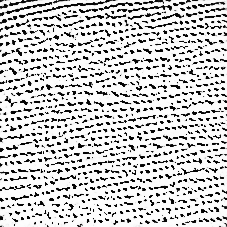

In [22]:
_ = render.render_vis(model, "conv2/Relu:40", param_f=lambda : param.color.to_valid_rgb(param.spatial.pixel_image((1,227,227,1))))

In [16]:
obj = lambda n: objectives.channel("conv2/Relu",n)

def show_feature(layer,n):
    with tf.Graph().as_default() as graph, tf.Session() as sess:
        optimizer = tf.train.AdamOptimizer(0.05)
        T = render.make_vis_T_grad(model,
                             objectives.channel(layer,n),
                             param_f=lambda : param.color.to_valid_rgb(param.spatial.pixel_image((1,227,227,1))),
                             relu_gradient_override=False,
                             optimizer = optimizer)

        loss, grads, vis_op, t_image = T("loss"), T("grads"), T("vis_op"), T("input")
        tf.global_variables_initializer().run()
        norm_gradient = tf.norm(grads[0][0])
        
        try:
            losses = []
            grads_list = []
            for i in tqdm(range(512)):
                loss_,_,n_grad = sess.run([loss,vis_op, norm_gradient])
                losses.append(loss_)
                grads_list.append(n_grad)

            vis=t_image.eval()
            print(loss_)
    
        except KeyboardInterrupt:
            log.warning("Interrupted optimization at step {:d}.".format(i+1))
            vis = t_image.eval()
            show(np.hstack(vis))
            
        plt.figure()
        plt.plot(losses)        
        plt.figure()
        plt.plot(grads_list)
        plt.figure()
        plt.imshow(vis[0,:,:,0])


100%|██████████| 512/512 [00:10<00:00, 50.81it/s]


121.737656


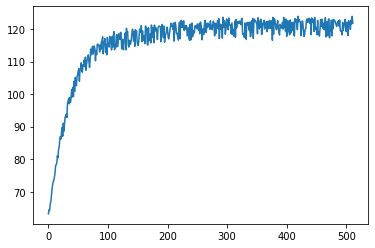

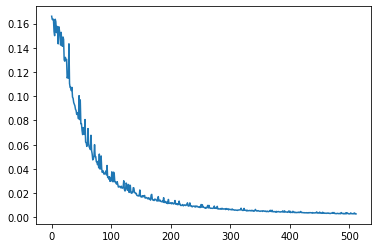

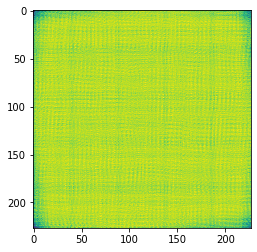

In [10]:
show_feature('conv1/Relu',50)

100%|██████████| 512/512 [00:13<00:00, 37.35it/s]


8275.042


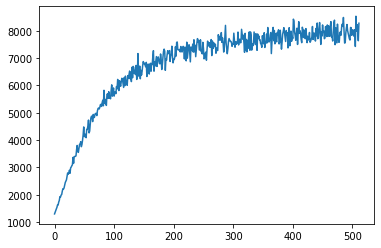

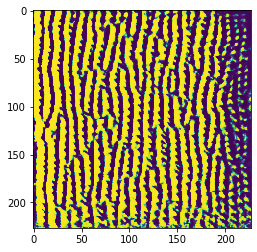

In [20]:
show_feature('conv2/Relu',2)

100%|██████████| 512/512 [00:14<00:00, 35.76it/s]


87700.39


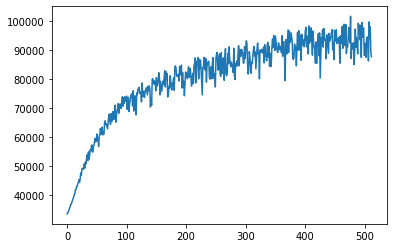

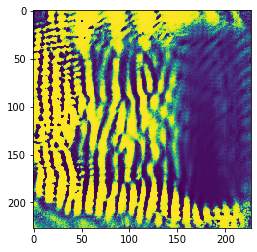

In [21]:
show_feature('conv3/Relu',50)

100%|██████████| 512/512 [00:13<00:00, 38.27it/s]


0.0


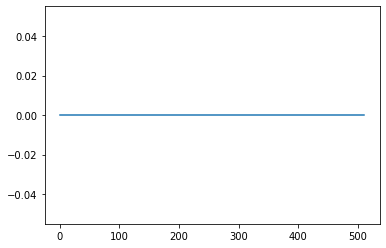

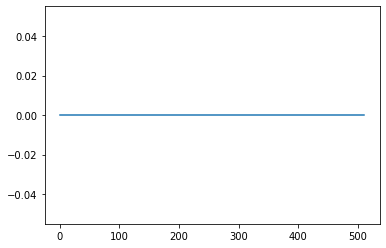

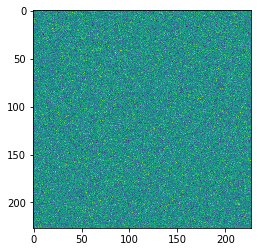

In [17]:
show_feature('conv4/Relu',100)

100%|██████████| 512/512 [00:15<00:00, 32.75it/s]


0.0


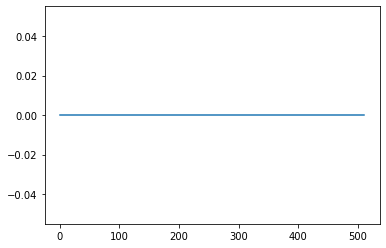

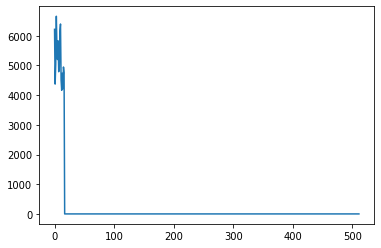

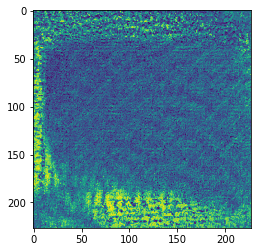

In [12]:
show_feature('conv5/Relu',20)